<h1><center>Сегментация изображений</center></h1>

## Домашнее задание

1. Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ
2. Обучить модель на выбор из [segmentation_models_pytorch](https://segmentation-modelspytorch.readthedocs.io/en/latest/index.html)


In [16]:
!pip install segmentation-models-pytorch

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 58.8/58.8 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 68.5/68.5 kB 3.6 MB/s eta 0:00:00
   ---------------------------------------- 106.7/106.7 kB 3.0 MB/s eta 0:00:00
   ---------------------------------------- 2.2/2.2 MB 7.3 MB/s eta 0:00:00
   ---------------------------------------- 311.7/311.7 kB 9.7 MB/s eta 0:00:00
   ---------------------------------------- 277.8/277.8 kB 8.6 MB/s eta 0:00:00
   ---------------------------------------- 169.0/169.0 kB 9.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=4e2a9fec228e7fceaf4126526a36498bbaa6628dbfa0eb000

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn
from torchsummary import summary
import torchvision

from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Linknet
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import segmentation_models_pytorch.utils as smp_utils

#### Подготовка датасета

In [105]:
MASK_PATH = "./set-lipstick-original/mask"
IMG_PATH = "./set-lipstick-original/720p"
LIST_PATH = "./set-lipstick-original/list.csv"

In [106]:
df = pd.read_csv(LIST_PATH)
df

filename  width  height class  xmin  ymin  xmax  ymax  \
0      image00000001.jpg   1280     720  Lips   661   394   776   444   
1      image00000002.jpg   1280     720  Lips   557   336   682   392   
2      image00000003.jpg   1280     720  Lips   553   369   684   427   
3      image00000004.jpg   1280     720  Lips   555   351   681   408   
4      image00000005.jpg   1280     720  Lips   555   351   680   407   
...                  ...    ...     ...   ...   ...   ...   ...   ...   
28589  image00028590.jpg   1280     720  Lips   657   347   817   450   
28590  image00028591.jpg   1280     720  Lips   713   325   884   388   
28591  image00028592.jpg   1280     720  Lips   659   401   808   488   
28592  image00028593.jpg   1280     720  Lips   689   334   839   431   
28593  image00028594.jpg   1280     720  Lips   657   381   817   476   

                   mask  
0      mask00000001.png  
1      mask00000002.png  
2      mask00000003.png  
3      mask00000004.png  
4      mask00000005.png  
...                 ...  
28589  mask00028590.png  
28590  mask00028591.png  
28591  mask00028592.png  
28592  mask00028593.png  
28593  mask00028594.png  

[28594 rows x 9 columns]

In [134]:
# Проверяем, все ли картинки имеют маски

In [109]:
list_images = sorted([i for i in Path(IMG_PATH).iterdir()])
list_masks = sorted([i for i in Path(MASK_PATH).iterdir()])
print ('кол-во фотографий:', len(list_images), '\n' 'кол-во масок:     ', len(list_masks))

кол-во фотографий: 28594 
кол-во масок:      28540


In [ ]:
# Удаляем картинки, у которых нет маски

In [110]:
df_images = df.loc[df['mask'].isin([i.name for i in list_masks])]
df_images.reset_index(drop=True, inplace=True)
df_images

filename  width  height class  xmin  ymin  xmax  ymax  \
0      image00000001.jpg   1280     720  Lips   661   394   776   444   
1      image00000002.jpg   1280     720  Lips   557   336   682   392   
2      image00000003.jpg   1280     720  Lips   553   369   684   427   
3      image00000004.jpg   1280     720  Lips   555   351   681   408   
4      image00000005.jpg   1280     720  Lips   555   351   680   407   
...                  ...    ...     ...   ...   ...   ...   ...   ...   
28535  image00028590.jpg   1280     720  Lips   657   347   817   450   
28536  image00028591.jpg   1280     720  Lips   713   325   884   388   
28537  image00028592.jpg   1280     720  Lips   659   401   808   488   
28538  image00028593.jpg   1280     720  Lips   689   334   839   431   
28539  image00028594.jpg   1280     720  Lips   657   381   817   476   

                   mask  
0      mask00000001.png  
1      mask00000002.png  
2      mask00000003.png  
3      mask00000004.png  
4      mask00000005.png  
...                 ...  
28535  mask00028590.png  
28536  mask00028591.png  
28537  mask00028592.png  
28538  mask00028593.png  
28539  mask00028594.png  

[28540 rows x 9 columns]

In [111]:
df = df_images.head(14000)

In [112]:
import os

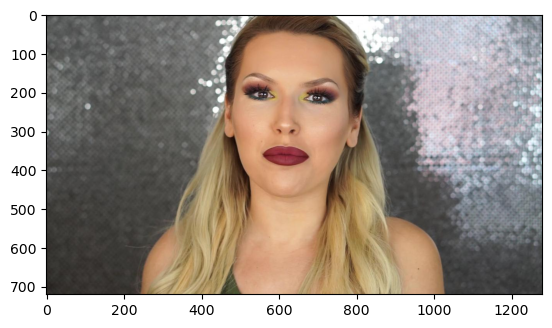

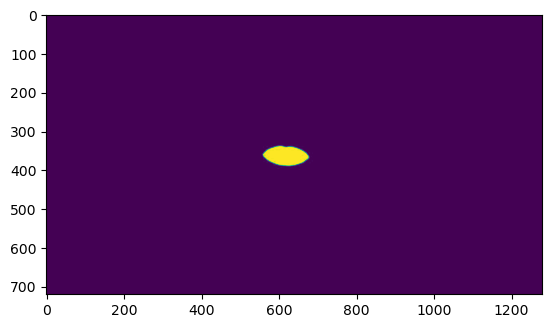

In [113]:
#проверка изображения и ее маски
img_path = os.path.join(IMG_PATH, df.iloc[1]['filename'])
mask_path = os.path.join(MASK_PATH, df.iloc[1]['mask'])

img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_RGB2BGR)
mask = cv2.imread(mask_path)[:, :, 1]

plt.imshow(img)
plt.show()

plt.imshow(mask)
plt.show()

In [114]:
class Lips_Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __getitem__(self, idx):
        data = self.df.iloc[idx]
        
        img_path = os.path.join(IMG_PATH, data['filename'])
        mask_path = os.path.join(MASK_PATH, data['mask'])
        
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_RGB2BGR)
        mask = cv2.imread(mask_path)#[:, :, 1]
        
        if self.transform:
            img, mask = self.transform(img, mask)
            return img, mask
    
    def __len__(self):
        return len(self.df)

In [115]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = logits
        m1 = probs.reshape(num, -1)
        m2 = targets.reshape(num, -1)
        intersection = (m1 * m2)

        score = (2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - (score.sum() / num)
        return score

In [116]:
import torchvision.transforms as transforms

In [117]:
to_tensor = transforms.ToTensor()

In [118]:
def mask_img_resize(img, mask, shape = (256, 256)): 
    img, mask = cv2.resize(img, shape), cv2.resize(mask, shape)
    return to_tensor(img), to_tensor(mask)

In [119]:
train_df, test_df = train_test_split(df, test_size = 0.25, random_state = 10)

In [120]:
train_df

filename  width  height class  xmin  ymin  xmax  ymax  \
8480   image00008481.jpg   1280     720  Lips   619   318   711   366   
11001  image00011056.jpg   1280     720  Lips   345   410   535   500   
3272   image00003273.jpg   1280     720  Lips   595   351   695   422   
9275   image00009276.jpg   1280     720  Lips   651   324   743   380   
5546   image00005547.jpg   1280     720  Lips   462   354   656   436   
...                  ...    ...     ...   ...   ...   ...   ...   ...   
11633  image00011688.jpg   1280     720  Lips   731   343   852   407   
1344   image00001345.jpg   1280     720  Lips   690   363   779   411   
12815  image00012870.jpg   1280     720  Lips   600   479   794   583   
7293   image00007294.jpg   1280     720  Lips   603   387   696   436   
1289   image00001290.jpg   1280     720  Lips   686   356   772   406   

                   mask  
8480   mask00008481.png  
11001  mask00011056.png  
3272   mask00003273.png  
9275   mask00009276.png  
5546   mask00005547.png  
...                 ...  
11633  mask00011688.png  
1344   mask00001345.png  
12815  mask00012870.png  
7293   mask00007294.png  
1289   mask00001290.png  

[10500 rows x 9 columns]

In [121]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df

filename  width  height class  xmin  ymin  xmax  ymax  \
0      image00008481.jpg   1280     720  Lips   619   318   711   366   
1      image00011056.jpg   1280     720  Lips   345   410   535   500   
2      image00003273.jpg   1280     720  Lips   595   351   695   422   
3      image00009276.jpg   1280     720  Lips   651   324   743   380   
4      image00005547.jpg   1280     720  Lips   462   354   656   436   
...                  ...    ...     ...   ...   ...   ...   ...   ...   
10495  image00011688.jpg   1280     720  Lips   731   343   852   407   
10496  image00001345.jpg   1280     720  Lips   690   363   779   411   
10497  image00012870.jpg   1280     720  Lips   600   479   794   583   
10498  image00007294.jpg   1280     720  Lips   603   387   696   436   
10499  image00001290.jpg   1280     720  Lips   686   356   772   406   

                   mask  
0      mask00008481.png  
1      mask00011056.png  
2      mask00003273.png  
3      mask00009276.png  
4      mask00005547.png  
...                 ...  
10495  mask00011688.png  
10496  mask00001345.png  
10497  mask00012870.png  
10498  mask00007294.png  
10499  mask00001290.png  

[10500 rows x 9 columns]

In [122]:
train_data = Lips_Dataset(train_df, transform = mask_img_resize)
test_data = Lips_Dataset(test_df, transform = mask_img_resize)

In [123]:
train_data_loader = DataLoader(train_data, batch_size=24, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=6, shuffle=False)

In [124]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [125]:
#создание модели
BACKBONE = 'resnet101'
segmodel = smp.Linknet(BACKBONE,activation = 'sigmoid', encoder_depth=5, encoder_weights='imagenet', decoder_use_batchnorm=True, in_channels=3, classes=1).to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

In [126]:
dataset = Lips_Dataset(df, transform = mask_img_resize)

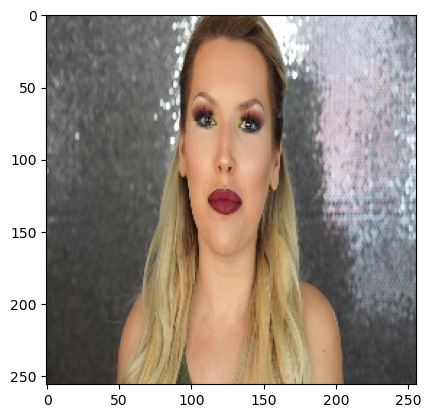

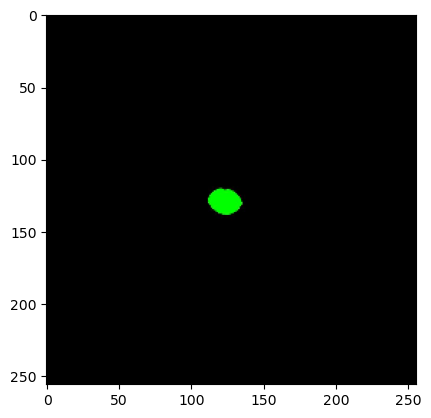

In [127]:
img, mask = dataset[1]

plt.imshow(img.permute(1, 2, 0))
plt.show()

plt.imshow(np.squeeze(mask.permute(1, 2, 0)), cmap='gray')
plt.show()

In [128]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

In [129]:
# цикл перебора выборок dataloader
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [130]:
torch.cuda.is_available()

True

In [131]:
# тренировка модели

max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|████████████████████████████████| 584/584 [01:17<00:00,  7.58it/s, dice_loss - 0.07558, iou_score - 0.8874]
Model saved!


In [132]:
# Функция построения изображения формата 255х255, исходной маски и предсказанной маски

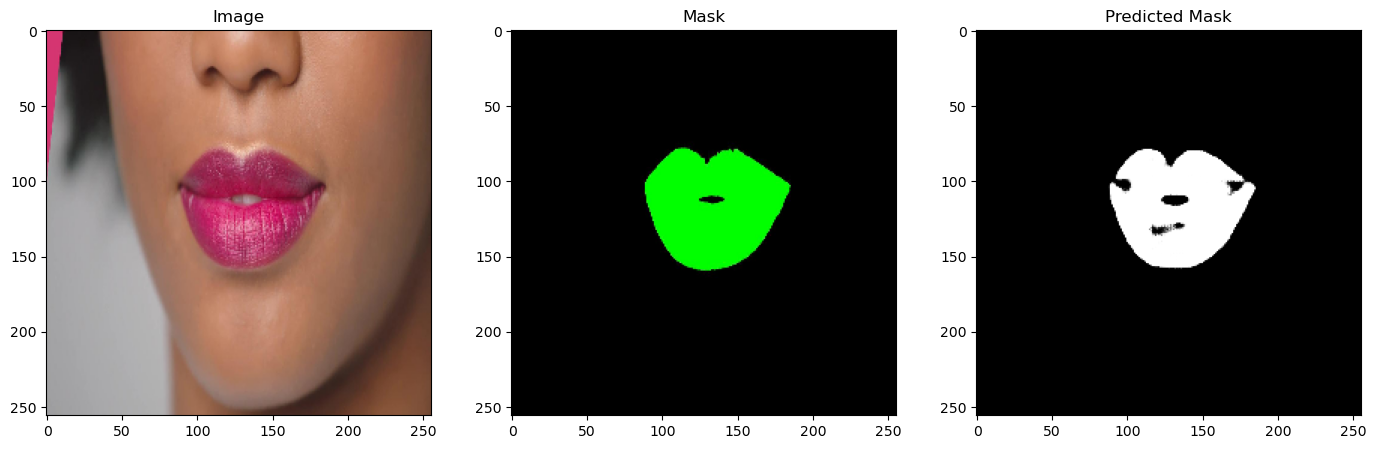

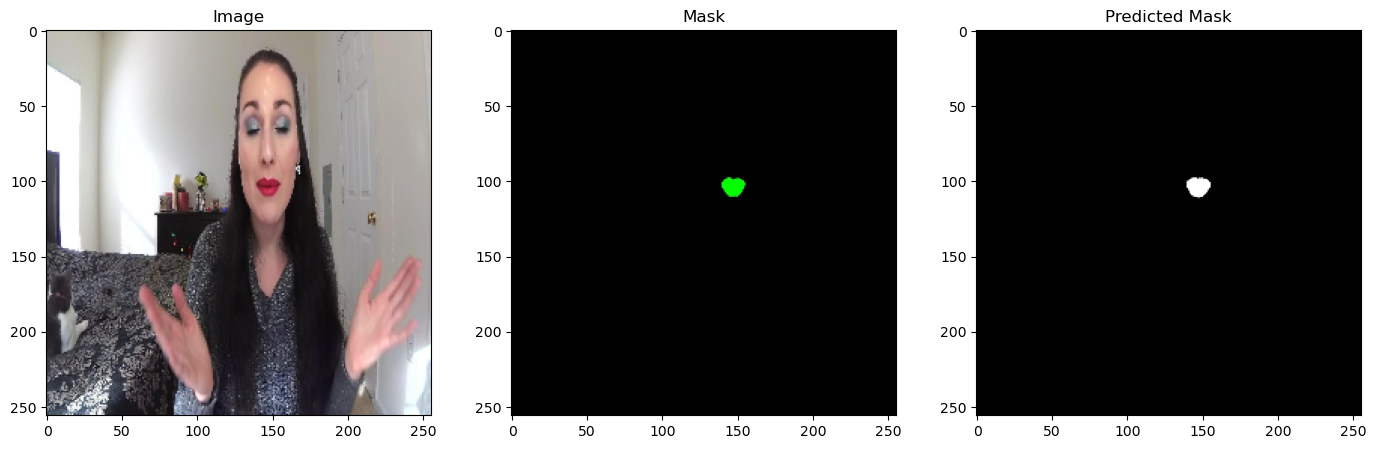

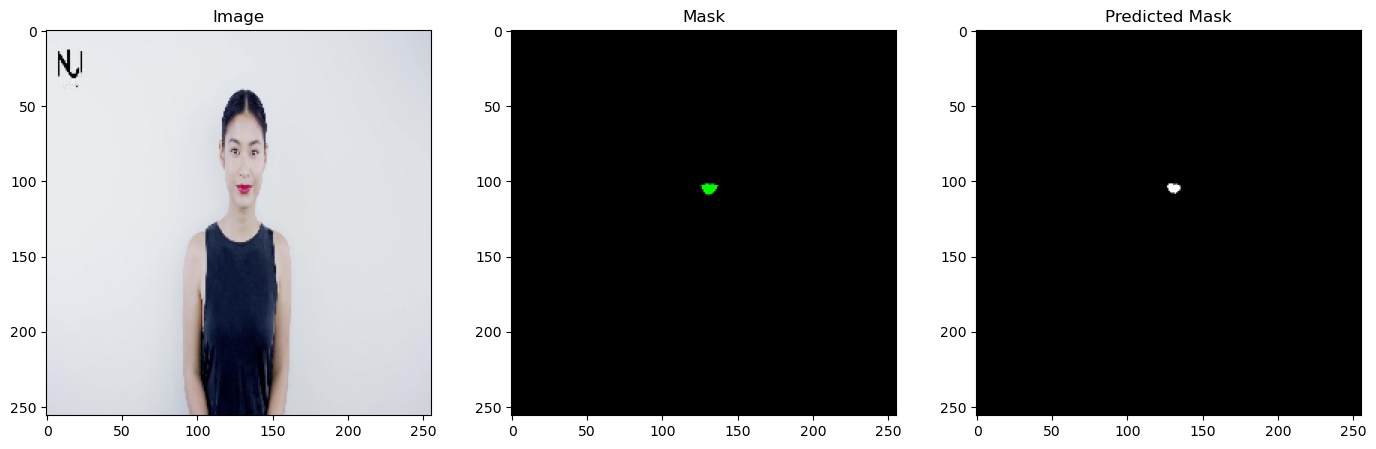

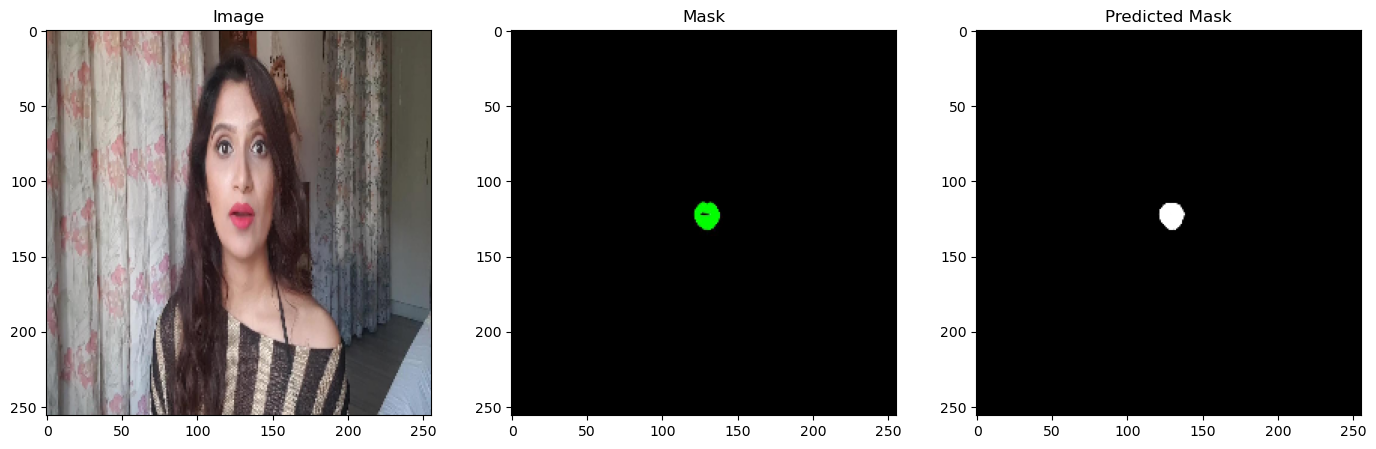

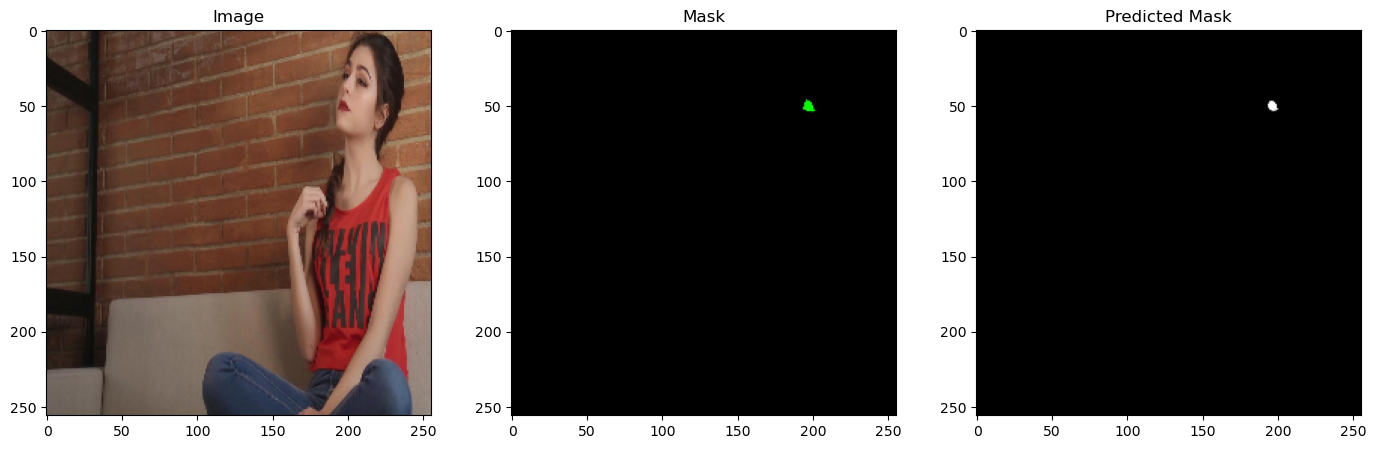

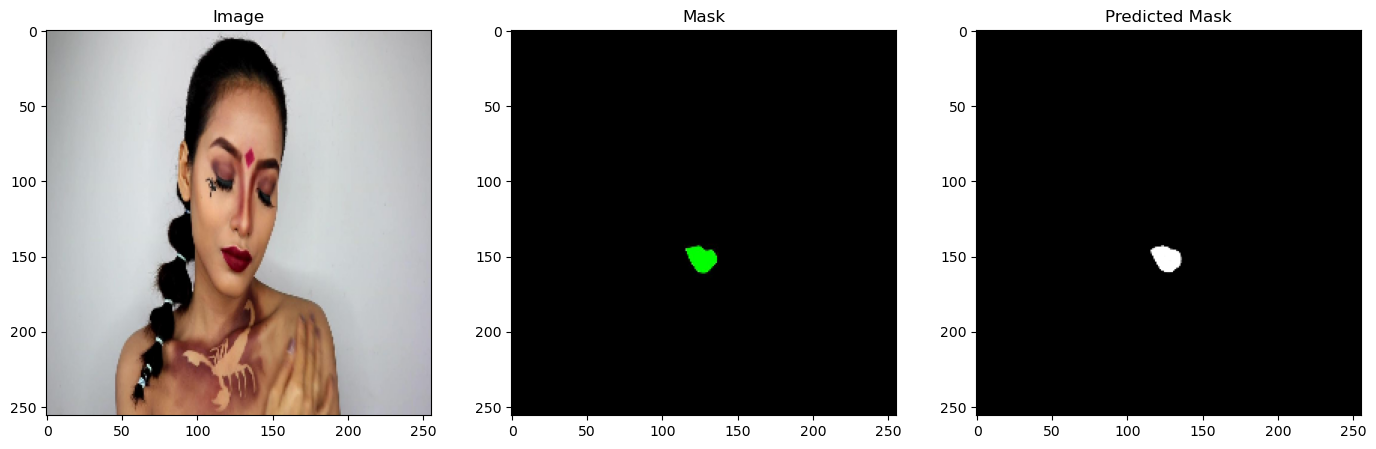

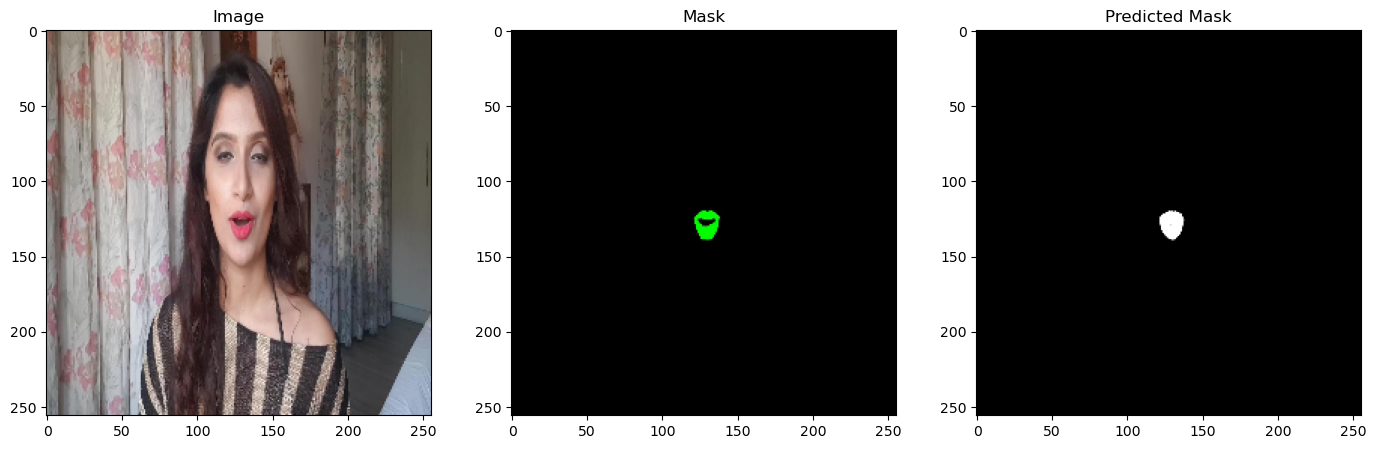

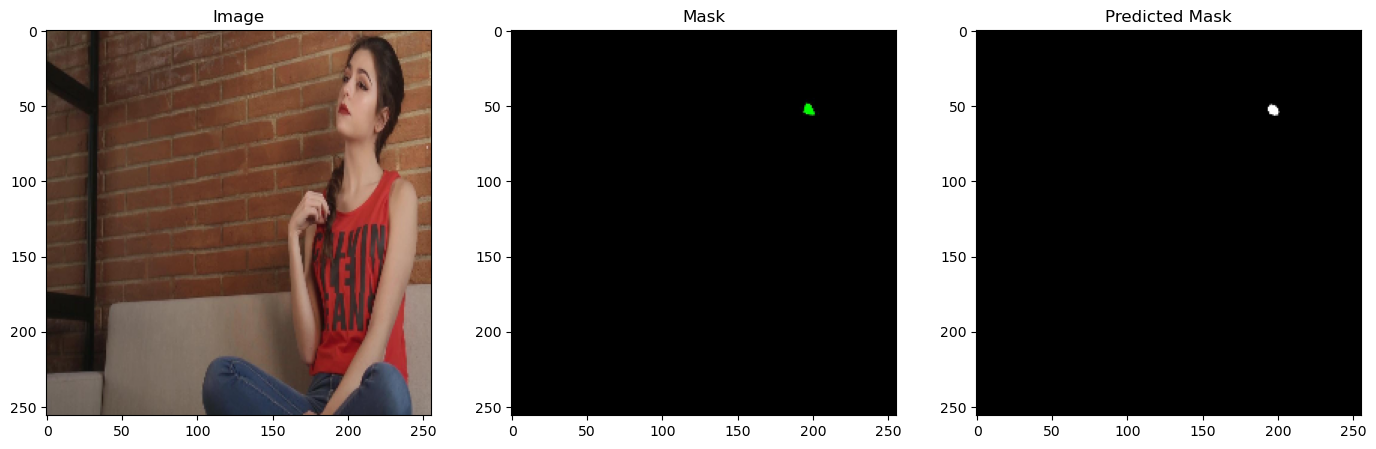

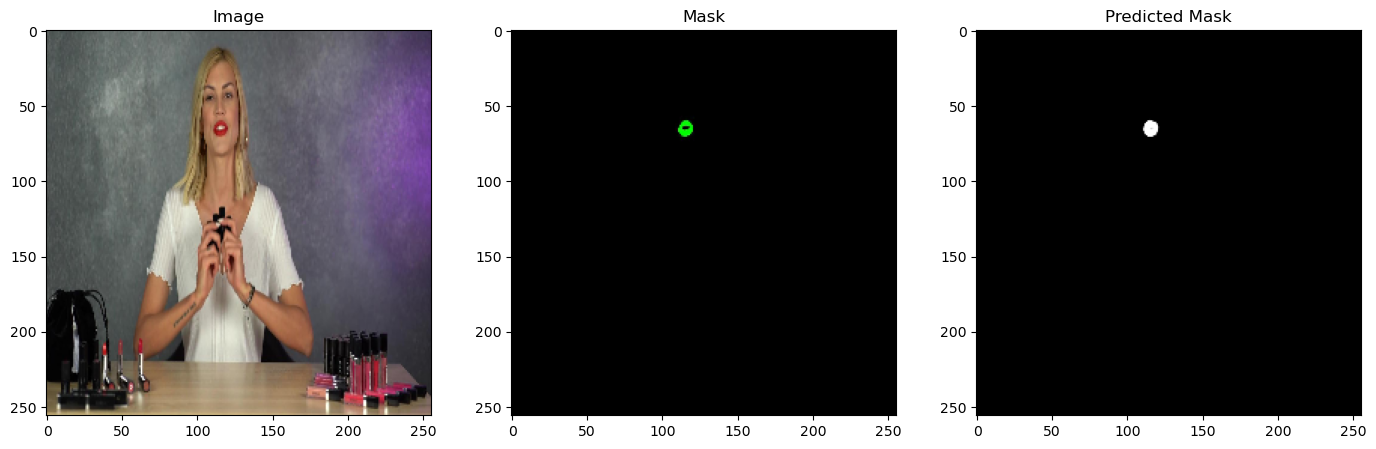

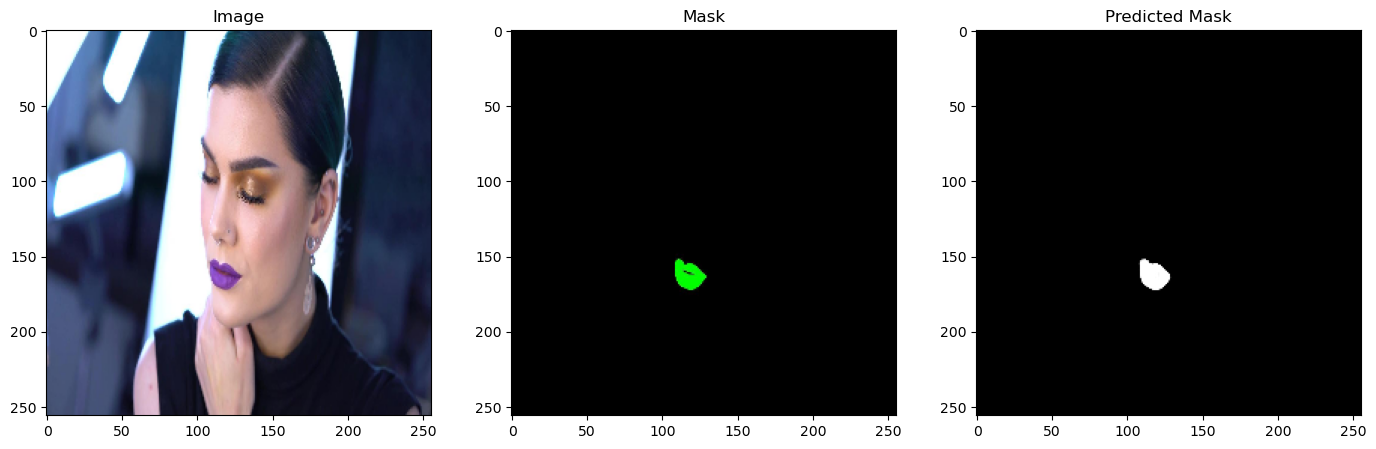

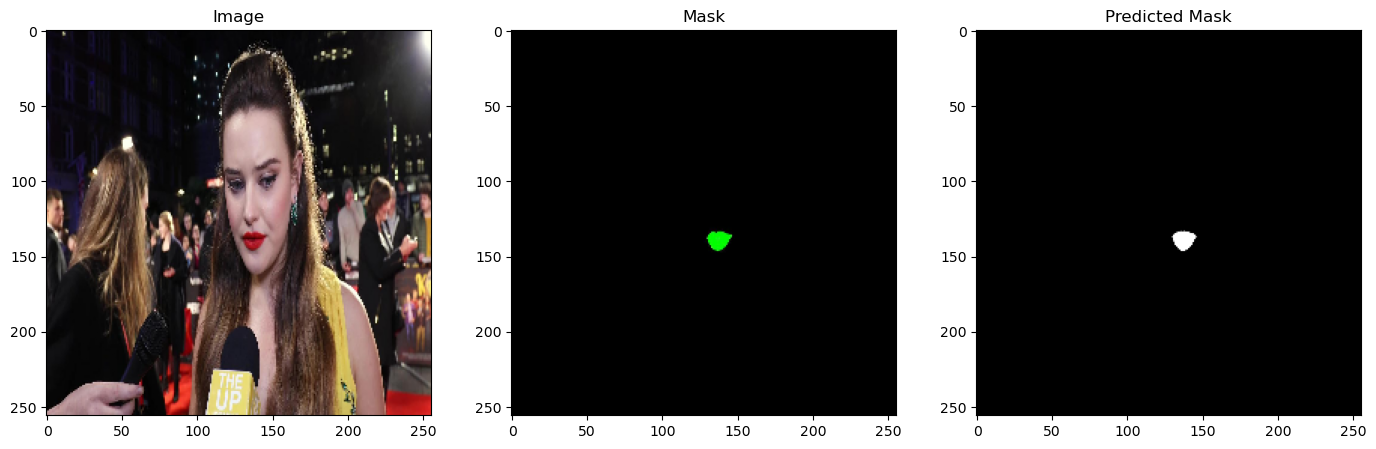

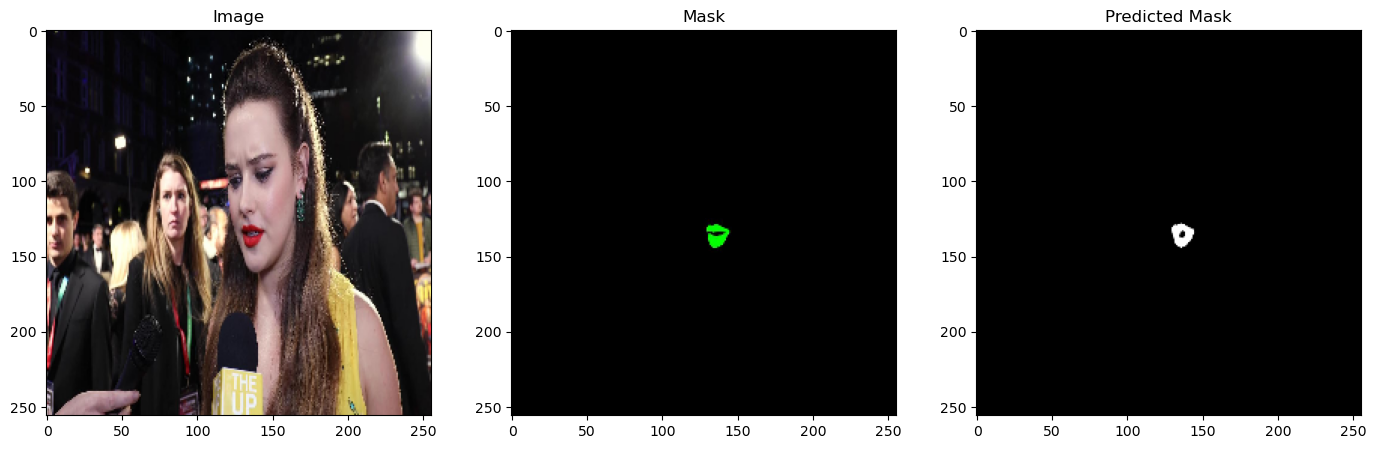

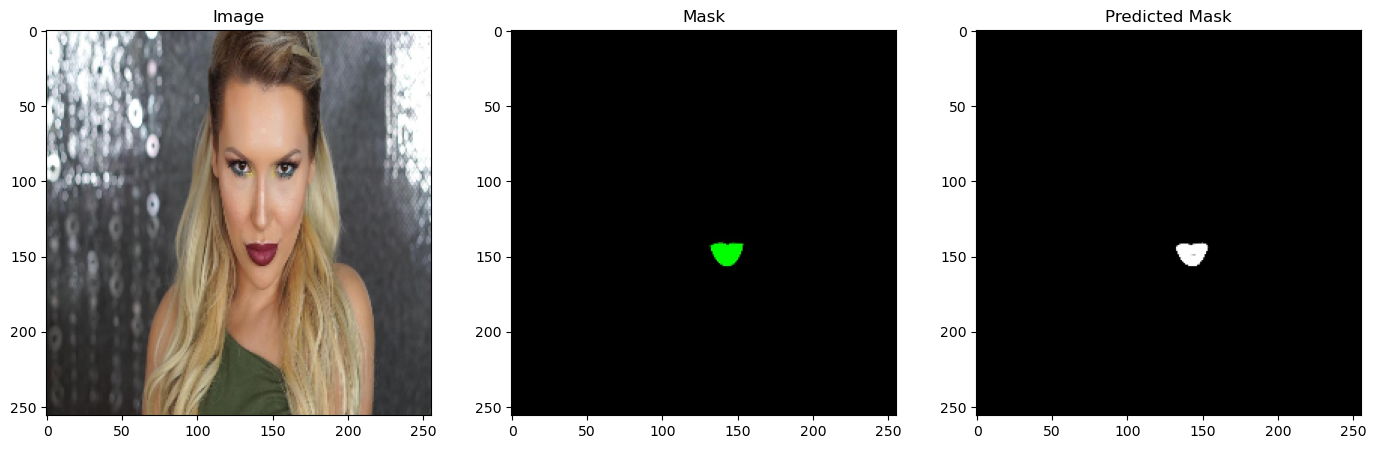

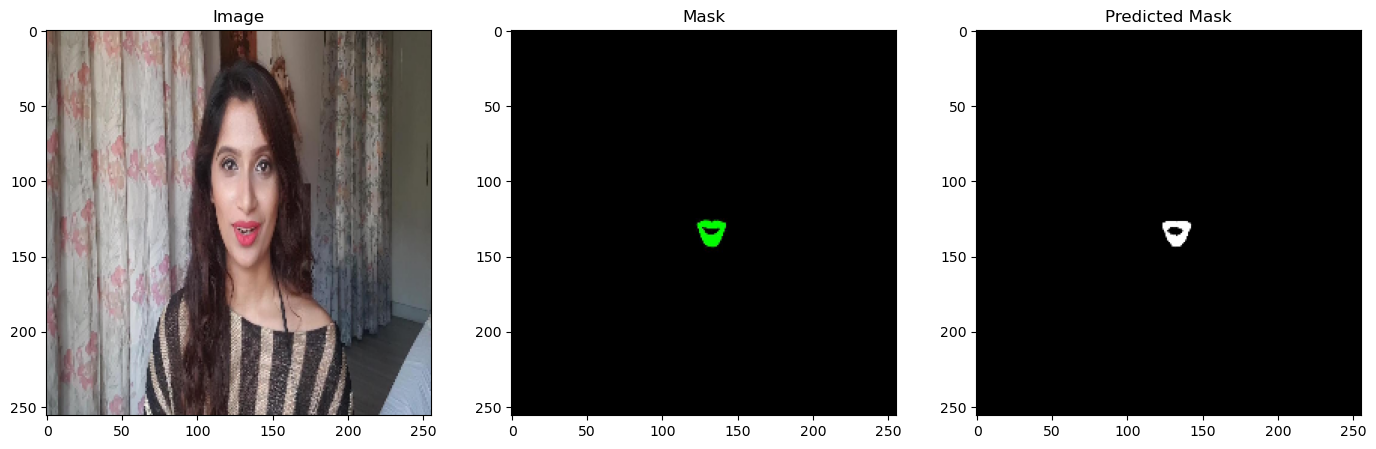

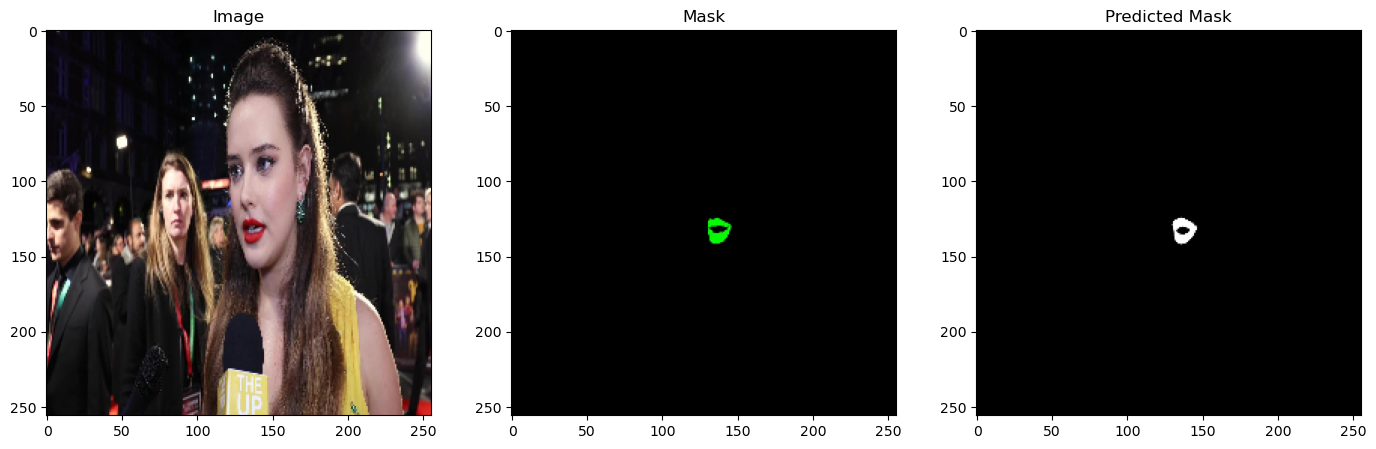

In [133]:
def draw_imgs(img, mask, pred_mask):
    
    fig, ax = plt.subplots(1, 3, figsize=(17, 5))

    ax[0].imshow(img.cpu().permute(1, 2, 0))
    ax[0].set_title('Image')

    ax[1].imshow(mask.cpu().permute(1, 2, 0), cmap='gray')
    ax[1].set_title('Mask')

    ax[2].imshow(np.squeeze(pred_mask.detach().cpu().permute(1, 2, 0)), cmap='gray')
    ax[2].set_title('Predicted Mask')

    plt.show()

indices = np.random.randint(len(test_data), size=15)

segmodel.eval()
with torch.no_grad():
    for idx in indices:
        img, mask = test_data[idx]
        pred_mask = segmodel(img[np.newaxis, :, :, :].to(device))

        draw_imgs(img, mask, pred_mask[0, ...])